In [1]:
import json
import os
import subprocess
import glob

import numpy as np
from pathlib import Path
import yaml
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from matplotlib.ticker import MaxNLocator
import lossmaps as lm
import xobjects as xo

import xtrack as xt
import xcoll as xc

import lossmaps as lm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import xarray as xr

import json
import copy

import xtrack as xt
import xpart as xp
import xobjects as xo


import pickle 
import h5py
import io
import scipy
from scipy.optimize import curve_fit

import ast

from scipy.special import erf
import scipy.optimize as opt
from matplotlib.ticker import FixedLocator
from scipy.stats import norm

import uproot 


In [2]:
! ls ./Data

Ang_scan_1TeV.h5		 MD_LS_energy3000_scan2.h5
MD_LinearScan_simulated_1000.h5  MD_LS_energy5000_scan1.h5
MD_LinearScan_simulated_3000.h5  MD_LS_sim1000.h5
MD_LinearScan_simulated_450.h5	 MD_LS_sim3000.h5
MD_LinearScan_simulated_5000.h5  MD_LS_sim450.h5
MD_LS_energy1000_scan1.h5	 MD_LS_sim5000.h5


In [3]:



beta_CRY =  202.14283989353822
alpha_CRY = -3.542768392822383

beta_COLL =   151.98832189100114
alpha_COLL =  1.5212968243622182

deltaphi_CRY_COLL = 0.3320954889610304

CO_TCP = -5.424275667608168e-07
beta_TCP = 140.75752795686023

In [4]:
def erfunc(x,a,b,c,d):
	return a+(b/2.0)*erf((x-c)/(d*np.sqrt(2.0)))

def calc_emittance(energy):
	mp = 0.9382
	emittance_n = 3.5e-6
	gamma = energy/mp
	beta = np.sqrt(1-1/(gamma*gamma))
	return emittance_n/(beta*gamma)

# data


In [175]:
datafile_1000 = "./Data/MD_LS_energy1000_scan1.h5"
sim_file_1000 = "./Data/MD_LS_sim1000.h5"
datafile_3000 = "./Data/MD_LS_energy3000_scan2.h5"
sim_file_3000 = "./Data/MD_LS_sim3000.h5"
datafile_5000 = "./Data/MD_LS_energy5000_scan1.h5"
sim_file_5000 = "./Data/MD_LS_sim5000.h5"
sim_file_450 = "./Data/MD_LS_sim450.h5"

In [176]:
LSdata_data_1000 = pd.read_hdf(datafile_1000, key='LSdata') 
LSsim_data_1000 = pd.read_hdf(sim_file_1000, key='LSdata')
metadata_data_1000 = pd.read_hdf(datafile_1000, key='metadata')
metadata_sim_1000 = pd.read_hdf(sim_file_1000, key='metadata')

LSdata_data_3000 = pd.read_hdf(datafile_3000, key='LSdata') 
LSsim_data_3000 = pd.read_hdf(sim_file_3000, key='LSdata')
metadata_data_3000 = pd.read_hdf(datafile_3000, key='metadata')
metadata_sim_3000 = pd.read_hdf(sim_file_3000, key='metadata')


LSdata_data_5000 = pd.read_hdf(datafile_5000, key='LSdata') 
LSsim_data_5000 = pd.read_hdf(sim_file_5000, key='LSdata')
metadata_data_5000 = pd.read_hdf(datafile_5000, key='metadata')
metadata_sim_5000 = pd.read_hdf(sim_file_5000, key='metadata')

LSsim_data_450 = pd.read_hdf(sim_file_450, key='LSdata')
metadata_sim_450 = pd.read_hdf(sim_file_450, key='metadata')

In [177]:
LSsim_data_450

,CollPos,Counts,CollPos_thetaframe
0,0.032510,0.000000e+00,520.846359
1,0.032410,4.066251e-07,518.847973
2,0.032310,4.066251e-07,516.849587
3,0.032209,4.066251e-07,514.851201
4,0.032109,4.066251e-07,512.852814
...,...,...,...
713,-0.038939,1.911097e+00,-904.002965
714,-0.039039,1.911097e+00,-906.001351
715,-0.039140,1.911097e+00,-907.999737
716,-0.039240,1.911097e+00,-909.998123


In [178]:
metadata_sim_450

,param0,param1,param2,param3,PosMaxErfFit,PosEnvelope,normal,theta_calc,deltax,beta_CRY,beta_COLL,deltaphi_CRY_COLL
0,0.428396,-0.856685,0.008881,0.000261,0.0082,0.006392,1.0,0.00005,0.002489,202.14284,151.988322,0.332095


In [180]:
def linscan_data(LSdata_data, metadata_data, box=True, plot_fit = True, plot_limit = True):

    fig, ax = plt.subplots(figsize=(10,5))	


    params = metadata_data['param0'].iloc[0], metadata_data['param1'].iloc[0], metadata_data['param2'].iloc[0], metadata_data['param3'].iloc[0]

    print('Height: ', abs(params[1]), ' a.u.')
    print('Mean: ', params[2], ' mm')
    print('Sigma: ', abs(params[3]), ' mm')

    # distance between centre of channeled beam and primary beam envelope
    deltax = metadata_data['deltax'].iloc[0]
    PosEnvelope = metadata_data['PosEnvelope'].iloc[0]
    RangetoMeanEnv = metadata_data['RangetoMeanEnv_min'].iloc[0], metadata_data['RangetoMeanEnv_max'].iloc[0]

    theta_calc = metadata_data['theta_calc'].iloc[0] #(deltax-n_sigma*np.sqrt(emittance*beta_COLL)*(np.cos(deltaphi_CRY_COLL)-1))/(np.sqrt(beta_CRY*beta_COLL)*np.sin(deltaphi_CRY_COLL))
    print('Calculated theta [urad]: ', round(theta_calc*1.0e6,3))

    #ax.plot(LSdata_data.CollPos, abs(params[1])*norm.pdf(LSdata_data.CollPos,params[2],abs(params[3])), label='Channeled profile', color='green')
    #ax.errorbar(LSdata_data.CollPos, LSdata_data.BLM_Coll_norm, yerr=LSdata_data.BLM_Coll_Err_norm, label='Data', marker='o', markersize=5)
    ax.plot(LSdata_data.CollPos, LSdata_data.BLM_Coll_norm, label='Data', marker='o', markersize=5)
    if plot_fit:
        ax.plot(LSdata_data.CollPos, erfunc(LSdata_data.CollPos, *params), label='Fit Data', zorder=10)

    #ax.plot(LSdata_data.CollPos, m * LSdata_data.CollPos + q, color='green', label='Channeled beam profile')

    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.set_xlabel('Linear Transverse Position [mm]', fontsize=12)
    ax.set_ylabel('BLM signal (flux-normalized) [a.u.]', fontsize=12)

    if plot_fit*plot_limit:
        ax.hlines(y=1, xmin=PosEnvelope-RangetoMeanEnv[0], xmax=PosEnvelope+RangetoMeanEnv[1], linewidth=2, color='k', linestyles='--')

    ax2 = ax.twiny()
    ax2.plot(LSdata_data.CollPos_thetaframe, LSdata_data.BLM_Coll_norm, alpha=0.0, color='k')
    ticks = ax2.get_xticks()
    ax2.xaxis.set_major_locator(FixedLocator(ticks))
    ax2.set_xticklabels([int(abs(tick)) for tick in ticks])
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.set_xlabel('Deflection angle [$\mu$rad]', fontsize=12)


    # ax.get_yaxis().set_visible(False)
    ax.set_ylim(0,2.5)
    ax.grid(color='gray', linestyle='--', linewidth=0.5)
    # ax.yaxis.grid(False)
    #plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    #lines1, labels1 = ax.get_legend_handles_labels()
    #plt.legend(lines1, labels1, fontsize=12)
    ax.grid(color='gray', linestyle='--', linewidth=0.5)
    textstr = 'Bending angle: %.2f $\mu$rad\nEfficiency: %.2f' % (round(theta_calc*1.0e6,3),round(abs(params[1])*100,2),)+'%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    if box:
        ax.text(0.4, 0.8, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)
    if plot_limit:
        ax2.axvline(0, color='grey', linestyle='--')
    ax.legend(fontsize=12)

    return fig, ax 

    #ax.axvline(PosMaxErfFit, color='r', linestyle='--')

    #ax.set_title(f'B2H LINEAR SCAN     Energy: {energy} GeV', fontsize=14)


In [181]:
def linscan_sim(LSsim_data, metadata_sim):
    
    beta_CRY = metadata_sim['beta_CRY'].iloc[0] 
    beta_COLL = metadata_sim['beta_COLL'].iloc[0]
    deltaphi_CRY_COLL = metadata_sim['deltaphi_CRY_COLL'].iloc[0]
    PosEnvelope = metadata_sim['PosEnvelope'].iloc[0] 
    PosMaxErfFit = metadata_sim['PosMaxErfFit'].iloc[0]   
    normalize = metadata_sim['normal'].iloc[0]
   

    def erfunc(x,a,b,c,d):
        return a+(b/2.0)*erf((x-c)/(d*np.sqrt(2.0)))

    params = metadata_sim['param0'].iloc[0], metadata_sim['param1'].iloc[0], metadata_sim['param2'].iloc[0], metadata_sim['param3'].iloc[0] # extras = opt.curve_fit(erfunc, self.LSdata[self.LSdata['CollPos'] > PosMaxErfFit].CollPos, self.LSdata[self.LSdata['CollPos'] > PosMaxErfFit].Counts, p0=param0)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(LSsim_data.CollPos, LSsim_data.Counts)
    #ax.plot(LSdata.CollPos, erfunc(LSdata.CollPos, param0[0], param0[1], param0[2], param0[3]))
    ax.plot(LSsim_data.CollPos, erfunc(LSsim_data.CollPos, params[0], params[1], params[2], params[3]))
    ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e3:.{2}f}" for x_tick in ax.get_xticks()])
    ax.axvline(PosMaxErfFit, color='r', linestyle='--')
    ax.axvline(PosEnvelope, color='g', linestyle='--')
    ax.axhline(1, color='b', linestyle='--')


    print('Height: ', abs(params[1]), ' a.u.')
    print('Mean: ', params[2], ' mm')
    print('Sigma: ', abs(params[3]), ' mm')


    # distance between centre of channeled beam and primary beam envelope
    deltax = (abs(params[2])-abs(PosEnvelope))

    theta_calc = metadata_sim['theta_calc'].iloc[0] # (deltax-self.n_sigma*np.sqrt(self.emittance*beta_COLL)*(np.cos(deltaphi_CRY_COLL)-1))/(np.sqrt(beta_CRY*beta_COLL)*np.sin(deltaphi_CRY_COLL))
    print('Calculated theta [urad]: ', round(theta_calc*1.0e6,3))



    ax2 = ax.twiny()
    ax2.plot(LSsim_data.CollPos_thetaframe, LSsim_data.Counts, alpha=0.0, color='k')
    ticks = ax2.get_xticks()
    ax2.xaxis.set_major_locator(FixedLocator(ticks))
    ax2.set_xticklabels([int(abs(tick)) for tick in ticks])
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.set_xlabel('Deflection angle [$\mu$rad]', fontsize=12)
    ax.set_xlabel('Linear Transverse Position [mm]', fontsize=12)
    #ax.plot(self.LSdata.CollPos, 0.0001*abs(params[1])*norm.pdf(self.LSdata.CollPos,params[2],abs(params[3])), label='Channeled profile', color='green')

    efficiency = round(abs(params[1])*100,2)
    print('Efficiency: ', efficiency, '%')
    textstr = 'Bending angle: %.2f $\mu$rad\nEfficiency: %.2f' % (round(theta_calc*1.0e6,3),round(abs(params[1])*100,2),)+'%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.4, 0.8, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)
    return ax



In [182]:
def linscan_merge(LSdata_data, metadata_data, LSsim_data_orig, metadata_sim, plot_lim =False, new_fit = False, param0=None, PosMaxErfFit = None, PosEnvelope= None, box=True, energy = 450, savefig = False, plot_lines= True):

    fig, ax = plt.subplots(figsize=(10,5))	
    LSsim_data = copy.deepcopy(LSsim_data_orig)
    LSsim_data.CollPos = LSsim_data.CollPos*1e3

    PosEnvelope_sim = metadata_sim['PosEnvelope'].iloc[0]  *1e3

 
    TCP_LU =  metadata_data['TCP_LU'].iloc[0]
    TCP_RU = metadata_data['TCP_RU'].iloc[0]

    emittance = calc_emittance(energy)
    sigma_TCP = np.sqrt(emittance*beta_TCP)
    hgap = (TCP_LU-TCP_RU)/2
    n_sigma = hgap/sigma_TCP



    if new_fit:
        df_tofit = LSdata_data[LSdata_data['CollPos'] > PosMaxErfFit]
        params, pcov = opt.curve_fit(erfunc, df_tofit.CollPos, df_tofit.BLM_Coll_norm, p0=param0, sigma=df_tofit.BLM_Coll_Err_norm)
        
        perr = np.sqrt(np.diag(pcov))
        print('Height: ', abs(params[1]), ' pm ', perr[1], ' a.u.')
        print('Mean: ', params[2],  ' pm ', perr[2],' mm')
        print('Sigma: ', abs(params[3]),' pm ', perr[3], ' mm')

        # distance between centre of channeled beam and primary beam envelope
        deltax = (abs(params[2])-abs(PosEnvelope))*1.0e-3
        theta_calc = (deltax-n_sigma*np.sqrt(emittance*beta_COLL)*(np.cos(deltaphi_CRY_COLL)-1))/(np.sqrt(beta_CRY*beta_COLL)*np.sin(deltaphi_CRY_COLL))
        print('New Theta: ', theta_calc)
    else:
        # distance between centre of channeled beam and primary beam envelope
        deltax = metadata_data['deltax'].iloc[0]
        params = metadata_data['param0'].iloc[0], metadata_data['param1'].iloc[0], metadata_data['param2'].iloc[0], metadata_data['param3'].iloc[0]
        PosEnvelope = metadata_data['PosEnvelope'].iloc[0]
        theta_calc = metadata_data['theta_calc'].iloc[0]
    RangetoMeanEnv = metadata_data['RangetoMeanEnv_min'].iloc[0], metadata_data['RangetoMeanEnv_max'].iloc[0]
     #(deltax-n_sigma*np.sqrt(emittance*beta_COLL)*(np.cos(deltaphi_CRY_COLL)-1))/(np.sqrt(beta_CRY*beta_COLL)*np.sin(deltaphi_CRY_COLL))
  

    params_sim = metadata_sim['param0'].iloc[0], metadata_sim['param1'].iloc[0], metadata_sim['param2'].iloc[0], metadata_sim['param3'].iloc[0]
    theta_calc_sim = metadata_sim['theta_calc'].iloc[0] #(deltax-n_sigma*np.sqrt(emittance*beta_COLL)*(np.cos(deltaphi_CRY_COLL)-1))/(np.sqrt(beta_CRY*beta_COLL)*np.sin(deltaphi_CRY_COLL))

    print('PosEnvelope: ', PosEnvelope)
    print('PosEnvelope_sim: ', PosEnvelope_sim)

    denv =    PosEnvelope_sim -PosEnvelope
    #denv = (TCP_LU - abs(TCP_RU))/2*1e3
    print('denv: ', denv)
    LSsim_data.CollPos = LSsim_data.CollPos - denv


 
    ax.plot(LSdata_data.CollPos, LSdata_data.BLM_Coll_norm, label='Data', marker='o', markersize=5)
    ax.plot(LSdata_data.CollPos, erfunc(LSdata_data.CollPos, *params), label='Fit Data', zorder=10)

    #ax.plot(LSdata_data.CollPos, m * LSdata_data.CollPos + q, color='green', label='Channeled beam profile')

    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.set_xlabel('Linear Transverse Position [mm]', fontsize=12)
    ax.set_ylabel('BLM signal (flux-normalized) [a.u.]', fontsize=12)
    if plot_lim:
        ax.hlines(y=1, xmin=PosEnvelope-RangetoMeanEnv[0], xmax=PosEnvelope+RangetoMeanEnv[1], linewidth=2, color='k', linestyles='--')

    ax2 = ax.twiny()
    ax2.plot(LSdata_data.CollPos_thetaframe, LSdata_data.BLM_Coll_norm, alpha=0.0, color='k')
    ticks = ax2.get_xticks()
    ax2.xaxis.set_major_locator(FixedLocator(ticks))
    ax2.set_xticklabels([int(abs(tick)) for tick in ticks])
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.set_xlabel('Deflection angle [$\mu$rad]', fontsize=12)


    # ax.get_yaxis().set_visible(False)
    ax.set_ylim(0,2.5)
    ax.set_xlim(0.0, 10)
    ax.grid(color='gray', linestyle='--', linewidth=0.5)
    # ax.yaxis.grid(False)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    #lines1, labels1 = ax.get_legend_handles_labels()
    #plt.legend(lines1, labels1, fontsize=12)
    ax.grid(color='gray', linestyle='--', linewidth=0.5)


    textstr = 'DATA Bending angle: %.2f $\mu$rad\nEfficiency: %.2f' % (round(theta_calc*1.0e6,3),round(abs(params[1])*100,2),)+'%'
    textstr_sim = '\nSIM Bending angle: %.2f $\mu$rad\nEfficiency: %.2f' % (round(theta_calc_sim*1.0e6,3),round(abs(params_sim[1])*100,2),)+'%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    if box:
        ax.text(0.4, 0.6, textstr+textstr_sim, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)

    if plot_lim:
        ax2.axvline(0, color='grey', linestyle='--')

    ax.plot(LSsim_data.CollPos, LSsim_data.Counts, label='Simulation')
    ax.legend(fontsize = 12)
    if plot_lines:
        ax.axvline(PosEnvelope_sim - denv, color='r', linestyle='--')
        ax.axvline(PosEnvelope, color='g', linestyle='--')
    #ax.axvline(PosMaxErfFit, color='r', linestyle='--')

    ax.set_title(f'B2H LINEAR SCAN     Energy: {energy} GeV', fontsize=14)
    if savefig:
        plt.savefig(f'./Data/LS_merge_{energy}.png')
    return fig, ax


# 1000 GeV

Height:  0.8730173668769929  a.u.
Mean:  0.006939690858775296  mm
Sigma:  0.0001717598709508704  mm
Calculated theta [urad]:  49.622
Efficiency:  87.3 %


(0.0, 2.5)

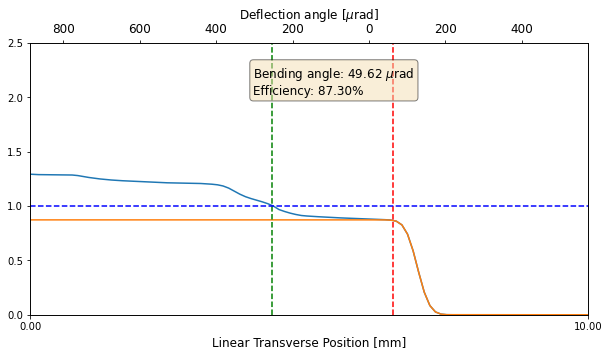

In [29]:
ax = linscan_sim(LSsim_data_1000, metadata_sim_1000)
ax.set_xlim(0.0, 0.01)
ax.set_ylim(0,2.5)

Height:  0.8237421259521482  a.u.
Mean:  6.4055452620947975  mm
Sigma:  0.2347543992751272  mm
Calculated theta [urad]:  50.248


(<Figure size 720x360 with 2 Axes>,
 <Axes: xlabel='Linear Transverse Position [mm]', ylabel='BLM signal (flux-normalized) [a.u.]'>)

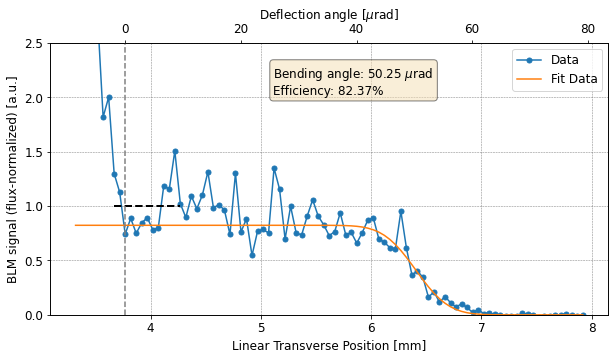

In [30]:
linscan_data(LSdata_data_1000, metadata_data_1000)

In [33]:
metadata_data_1000

,param0,param1,param2,param3,PosMaxErfFit,PosEnvelope,RangetoMeanEnv_min,RangetoMeanEnv_max,normal,normal_err,theta_calc,deltax,TCP_LU,TCP_RU
0,0.411381,-0.823742,6.405545,0.234754,5.5,3.77,0.1,0.5,3.134632e-12,7.502884e-13,0.00005,0.002636,0.004715,-0.003595


In [34]:
metadata_sim_1000

,param0,param1,param2,param3,PosMaxErfFit,PosEnvelope,normal,theta_calc,deltax,beta_CRY,beta_COLL,deltaphi_CRY_COLL
0,0.436556,-0.873017,0.00694,0.000172,0.0065,0.00434,1.0,0.00005,0.0026,202.142863,151.988264,0.332096


In [49]:
energy = 1000   
mp = 0.9382
emittance_n = 3.5e-6
gamma = energy/mp
beta = np.sqrt(1-1/(gamma*gamma))
emittance = emittance_n/(beta*gamma)


beta_CRY =  202.14283989353822
alpha_CRY = -3.542768392822383

beta_COLL =   151.98832189100114
alpha_COLL =  1.5212968243622182

deltaphi_CRY_COLL = 0.3320954889610304

CO_TCP = -5.424275667608168e-07
beta_TCP = 140.75752795686023

sigma_TCP = np.sqrt(emittance*beta_TCP)
sigma_COLL = np.sqrt(emittance*beta_COLL)
hgap = (metadata_data_1000["TCP_LU"]-metadata_data_1000["TCP_RU"])/2
n_sigma = hgap/sigma_TCP
n_sigma

0    6.111578
dtype: float64

PosEnvelope:  3.77
PosEnvelope_sim:  4.33993122599885
denv:  0.5699312259988498


(3.0, 8.5)

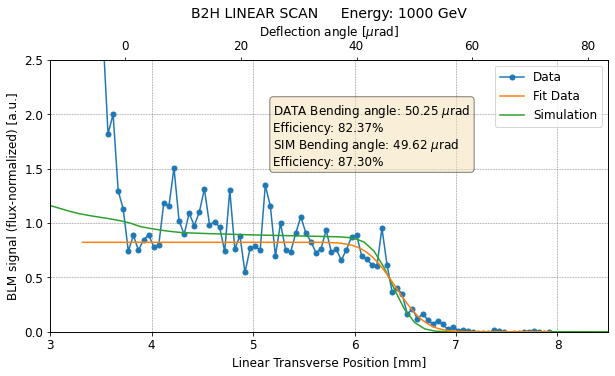

In [65]:
fig, ax = linscan_merge(LSdata_data_1000, metadata_data_1000, LSsim_data_1000, metadata_sim_1000, energy=1000, plot_lines=False, box = True)
ax.set_xlim(3, 8.5)
#ax.axvline(n_sigma[0]*sigma_COLL*1e3, color='r', linestyle='--')
#ax.axvline(metadata_data_1000["PosEnvelope"][0], color='k', linestyle='--')
#ax.axvline(metadata_sim_1000["PosEnvelope"][0]*1e3, color='r', linestyle='--')


Height:  0.90726714855419  pm  0.06799727226344034  a.u.
Mean:  6.36752692546116  pm  0.03883633326896257  mm
Sigma:  0.26766339435247016  pm  0.033802063368803634  mm
New Theta:  4.958248323540005e-05
denv:  0.5699312259988498


Text(0.5, 1.0, '')

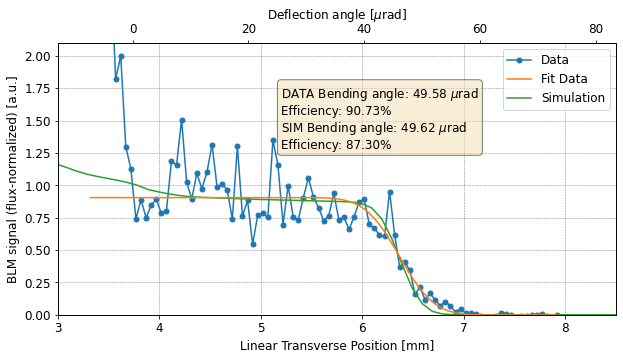

In [25]:
fig, ax = linscan_merge(LSdata_data_1000, metadata_data_1000, LSsim_data_1000, metadata_sim_1000, new_fit=True, param0=[0.5,-0.9,6.5,0.2], box= True, PosMaxErfFit=5.8, PosEnvelope=3.77, energy=1000, plot_lines=False)
ax.set_xlim(3, 8.5)
ax.set_ylim(0,2.1)
ax.set_title(None)

In [ ]:
 if new_fit:
        df_tofit = LSdata_data[LSdata_data['CollPos'] > PosMaxErfFit]
        params, pcov = opt.curve_fit(erfunc, df_tofit.CollPos, df_tofit.BLM_Coll_norm, p0=param0, sigma=df_tofit.BLM_Coll_Err_norm)
        
        perr = np.sqrt(np.diag(pcov))
        print('Height: ', abs(params[1]), ' pm ', perr[1], ' a.u.')
        print('Mean: ', params[2],  ' pm ', perr[2],' mm')
        print('Sigma: ', abs(params[3]),' pm ', perr[3], ' mm')

        # distance between centre of channeled beam and primary beam envelope
        deltax = (abs(params[2])-abs(PosEnvelope))*1.0e-3
        theta_calc = (deltax-n_sigma*np.sqrt(emittance*beta_COLL)*(np.cos(deltaphi_CRY_COLL)-1))/(np.sqrt(beta_CRY*beta_COLL)*np.sin(deltaphi_CRY_COLL))
        print('New Theta: ', theta_calc)
    else:
        # distance between centre of channeled beam and primary beam envelope
        deltax = metadata_data['deltax'].iloc[0]
        params = metadata_data['param0'].iloc[0], metadata_data['param1'].iloc[0], metadata_data['param2'].iloc[0], metadata_data['param3'].iloc[0]
        PosEnvelope = metadata_data['PosEnvelope'].iloc[0]
        theta_calc = metadata_data['theta_calc'].iloc[0]
    RangetoMeanEnv = metadata_data['RangetoMeanEnv_min'].iloc[0], metadata_data['RangetoMeanEnv_max'].iloc[0]
     #(deltax-n_sigma*np.sqrt(emittance*beta_COLL)*(np.cos(deltaphi_CRY_COLL)-1))/(np.sqrt(beta_CRY*beta_COLL)*np.sin(deltaphi_CRY_COLL))
  

Height:  0.8237421259521482  a.u.
Mean:  6.4055452620947975  mm
Sigma:  0.2347543992751272  mm
Calculated theta [urad]:  50.248


(<Figure size 720x360 with 2 Axes>,
 <Axes: xlabel='Linear Transverse Position [mm]', ylabel='BLM signal (flux-normalized) [a.u.]'>)

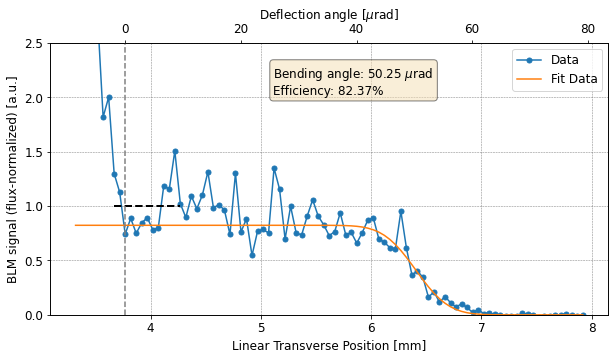

In [13]:
linscan_data(LSdata_data_1000, metadata_data_1000)

In [14]:
LSdata_data_1000

,CollPos,BLM_Coll,BLM_CRY,BeamInt,Time,BLM_Coll_Err,Theta,BLM_Coll_norm,BLM_Coll_Err_norm,CollPos_thetaframe
0,3.32,2.741217e-04,3.524109e-07,2.009581e+11,277.0,0.000237,13.328559,2.603610,2.250224,-8.579438
1,3.37,3.907833e-04,3.894196e-07,2.014822e+11,273.0,0.000180,12.453605,3.795591,1.746604,-7.626167
2,3.42,3.536835e-04,3.719279e-07,2.018126e+11,270.0,0.000143,11.578652,3.492717,1.409234,-6.672896
3,3.47,2.562845e-04,3.737691e-07,2.021471e+11,267.0,0.000095,10.703698,2.572770,0.953924,-5.719625
4,3.52,2.686612e-04,3.737691e-07,2.024158e+11,264.0,0.000136,9.828744,2.741142,1.385890,-4.766354
...,...,...,...,...,...,...,...,...,...,...
88,7.72,1.283220e-07,3.691661e-07,2.087385e+11,12.0,0.000003,-63.667382,0.001874,0.041190,75.308397
89,7.77,6.631985e-07,3.535156e-07,2.088199e+11,9.0,0.000002,-64.542336,0.009813,0.033273,76.261667
90,7.82,-3.964277e-07,3.544362e-07,2.089017e+11,6.0,0.000001,-65.417290,-0.005951,0.022315,77.214938
91,7.87,-9.377485e-07,3.562775e-07,2.089525e+11,3.0,0.000002,-66.292243,-0.014305,0.025139,78.168209


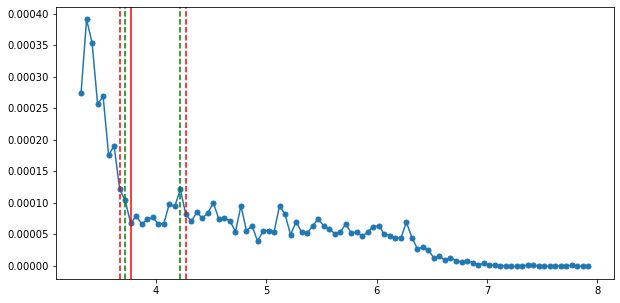

In [31]:
fig, ax = plt.subplots(figsize=(10,5))
#ax.errorbar(LSdata_data_1000.CollPos, LSdata_data_1000.BLM_Coll, yerr = LSdata_data_1000.BLM_Coll_Err,  marker='o', markersize=5)
ax.plot(LSdata_data_1000.CollPos, LSdata_data_1000.BLM_Coll,marker = 'o', markersize=5)
ax.axvline(metadata_data_1000['PosEnvelope'].iloc[0], color='r', linestyle='-')
ax.axvline(metadata_data_1000['PosEnvelope'].iloc[0]-metadata_data_1000['RangetoMeanEnv_min'].iloc[0], color='r', linestyle='--')
ax.axvline(metadata_data_1000['PosEnvelope'].iloc[0]+metadata_data_1000['RangetoMeanEnv_max'].iloc[0], color='r', linestyle='--')
ax.axvline(df_to_mean.iloc[0].CollPos, color='g', linestyle='--')   
ax.axvline(df_to_mean.iloc[-1].CollPos, color='g', linestyle='--')

In [28]:
df_to_mean = LSdata_data_1000[(LSdata_data_1000['CollPos'] > metadata_data_1000['PosEnvelope'].iloc[0]-metadata_data_1000['RangetoMeanEnv_min'].iloc[0]) & (LSdata_data_1000['CollPos'] < metadata_data_1000['PosEnvelope'].iloc[0]+metadata_data_1000['RangetoMeanEnv_max'].iloc[0])]

In [32]:
df_to_mean.BLM_Coll.mean()

8.294831224499327e-05

In [116]:
# DEF_PLOTS !!!!
fig.savefig('./DEF_PLOTS/MD_linear_scan_1000GeV.pdf', dpi=300)

In [29]:
TCP_LU =  2.86e-3
TCP_RU = -1.88e-3 

(TCP_LU - abs(TCP_RU))/2*1E3

0.4900000000000001

Height:  0.8730173668769929  a.u.
Mean:  0.006939690858775296  mm
Sigma:  0.0001717598709508704  mm
Calculated theta [urad]:  49.622
Efficiency:  87.3 %


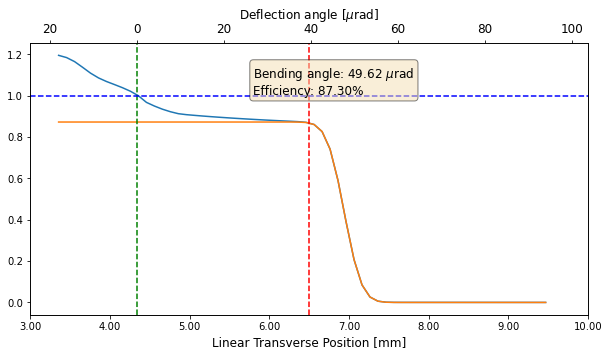

In [228]:
a = LSsim_data_1000[(LSsim_data_1000.Counts < 1.2) & (LSsim_data_1000.CollPos < 9.5e-3) ]
ax = linscan_sim(a, metadata_sim_1000)

In [229]:
a.to_hdf('./Data/MD_LinearScan_simulated_1000.h5', key='LinearScan', format='table', mode='a', complevel=9, complib='blosc')
metadata_sim_1000.to_hdf('./Data/MD_LinearScan_simulated_1000.h5', key='metadata', format='table', mode='a', complevel=9, complib='blosc')

# 3000 GeV

Height:  0.8286662224942495  a.u.
Mean:  0.005175003509387147  mm
Sigma:  9.421127749586289e-05  mm
Calculated theta [urad]:  49.59
Efficiency:  82.87 %


(0.0, 2.5)

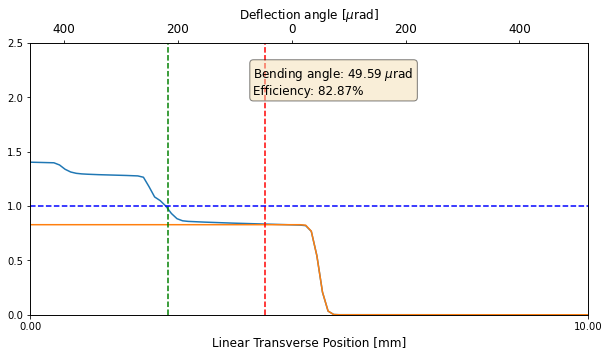

In [35]:
ax = linscan_sim(LSsim_data_3000, metadata_sim_3000)
ax.set_xlim(0.0, 0.01)
ax.set_ylim(0,2.5)

Height:  0.6175904995957343  a.u.
Mean:  4.897564590133499  mm
Sigma:  0.2098949438543342  mm
Calculated theta [urad]:  50.085


(0.0, 2.0)

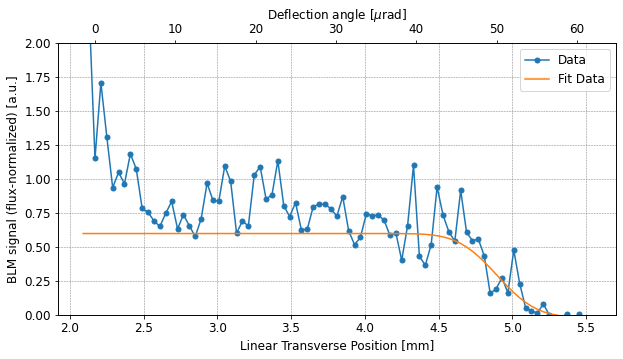

In [119]:
fig, ax = linscan_data(LSdata_data_3000, metadata_data_3000, box = False, plot_fit = True, plot_limit=False)
ax.set_ylim(0.0, 2)

In [120]:
fig.savefig('./DEF_PLOTS/MD_linear_scan_3000GeV.pdf', dpi=300)

In [ ]:
linscan_data(LSdata_data_3000, metadata_data_3000)

PosEnvelope:  2.17
PosEnvelope_sim:  2.4757226624965156
denv:  0.3057226624965157


(0.0, 3.0)

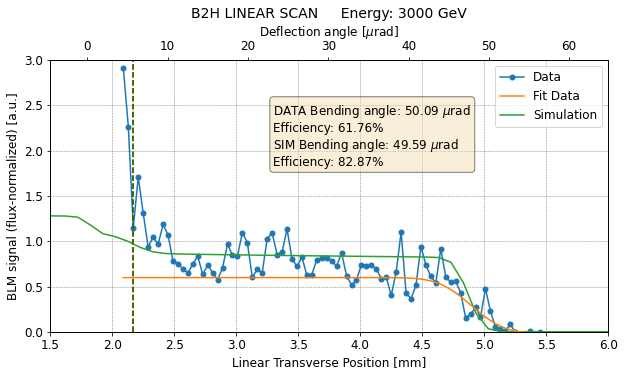

In [66]:
ax = linscan_merge(LSdata_data_3000, metadata_data_3000, LSsim_data_3000, metadata_sim_3000, energy = 3000)
ax[1].set_xlim(1.5, 6)
ax[1].set_ylim(0,3.0)

#ax[1].axvline(metadata_data_3000["PosEnvelope"][0], color='k', linestyle='--')
#ax[1].axvline(metadata_sim_3000["PosEnvelope"][0]*1e3, color='r', linestyle='--')

Height:  0.6405937285375284  pm  0.0683752379763333  a.u.
Mean:  4.887631279308998  pm  0.052166747389608005  mm
Sigma:  0.21872907702036473  pm  0.0720920192319731  mm
New Theta:  4.816082222203393e-05
denv:  0.2057226624965156


(0.0, 3.0)

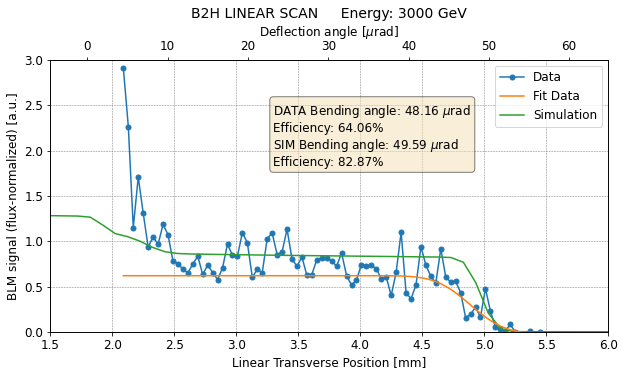

In [27]:
ax = linscan_merge(LSdata_data_3000, metadata_data_3000, LSsim_data_3000, metadata_sim_3000, new_fit=True, param0=[0.5, -0.61, 4.7, 0.5], PosMaxErfFit=3.5, PosEnvelope=2.27, energy = 3000, plot_lines=False)
ax[1].set_xlim(1.5, 6)
ax[1].set_ylim(0,3.0)

Height:  0.8286662224942495  a.u.
Mean:  0.005175003509387147  mm
Sigma:  9.421127749586289e-05  mm
Calculated theta [urad]:  49.59
Efficiency:  82.87 %


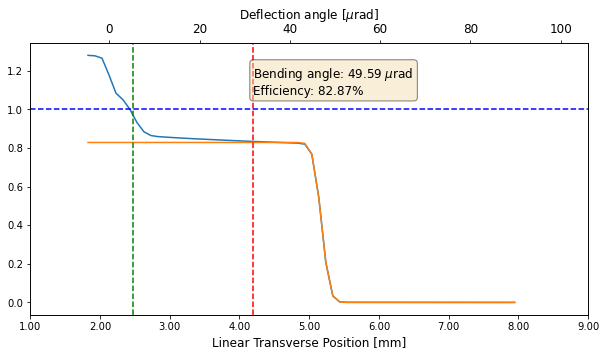

In [224]:
a = LSsim_data_3000[(LSsim_data_3000.Counts < 1.28) & (LSsim_data_3000.CollPos < 8e-3) ]
ax = linscan_sim(a, metadata_sim_3000)

In [225]:
a.to_hdf('./Data/MD_LinearScan_simulated_3000.h5', key='LinearScan', format='table', mode='a', complevel=9, complib='blosc')
metadata_sim_3000.to_hdf('./Data/MD_LinearScan_simulated_3000.h5', key='metadata', format='table', mode='a', complevel=9, complib='blosc')

# 5000 GeV

Height:  0.8115865913268562  a.u.
Mean:  0.004654539715295892  mm
Sigma:  6.780073026049329e-05  mm
Calculated theta [urad]:  49.598
Efficiency:  81.16 %


(0.0, 2.5)

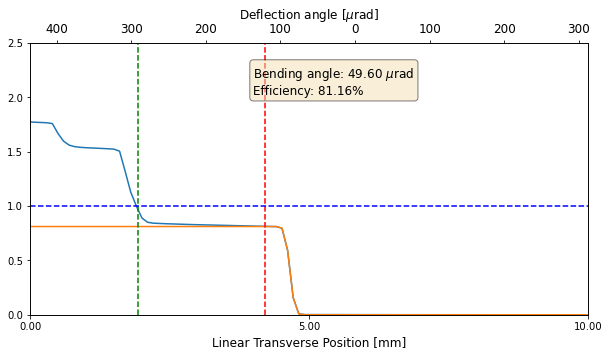

In [39]:
ax = linscan_sim(LSsim_data_5000, metadata_sim_5000)
ax.set_xlim(0.0, 0.01)
ax.set_ylim(0,2.5)

Height:  0.4650799026811937  a.u.
Mean:  4.4737791481430005  mm
Sigma:  0.062073991572250936  mm
Calculated theta [urad]:  52.819


(0.0, 2.0)

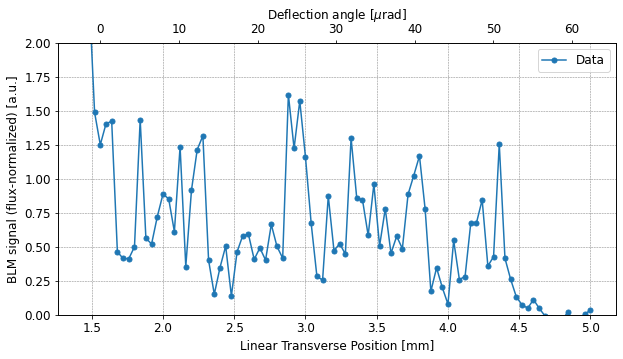

In [123]:
fig, ax = linscan_data(LSdata_data_5000, metadata_data_5000, box = False, plot_fit = False, plot_limit = False)
ax.set_ylim(0.0, 2)

In [124]:
fig.savefig('./DEF_PLOTS/MD_linear_scan_5000GeV.pdf', dpi=300)

PosEnvelope:  1.56
PosEnvelope_sim:  1.9248150622495075
denv:  0.36481506224950744


(1.0, 5.5)

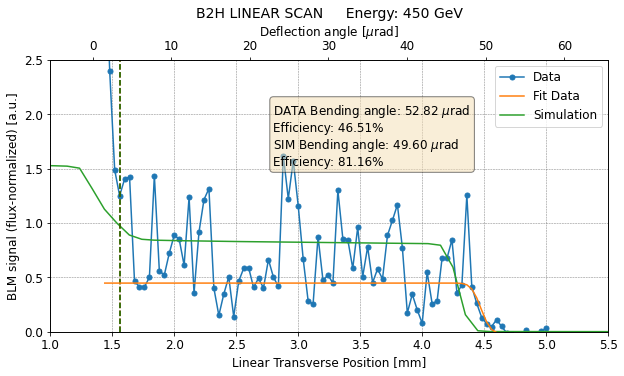

In [67]:
ax = linscan_merge(LSdata_data_5000, metadata_data_5000, LSsim_data_5000, metadata_sim_5000)
ax[1].set_xlim(1, 5.5)

#ax[1].axvline(metadata_data_5000["PosEnvelope"][0], color='k', linestyle='--')
#ax[1].axvline(metadata_sim_5000["PosEnvelope"][0]*1e3, color='r', linestyle='--')


Height:  0.8115865913268562  a.u.
Mean:  0.004654539715295892  mm
Sigma:  6.780073026049329e-05  mm
Calculated theta [urad]:  49.598
Efficiency:  81.16 %


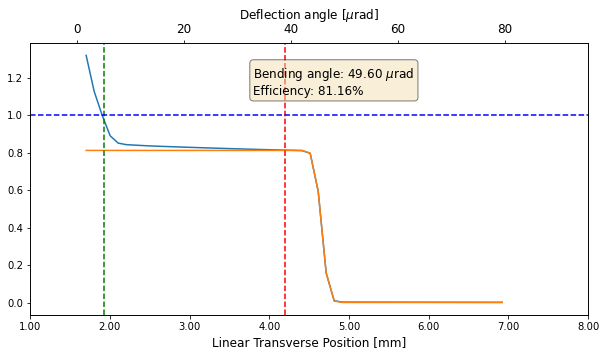

In [217]:
a = LSsim_data_5000[(LSsim_data_5000.Counts < 1.5) & (LSsim_data_5000.CollPos < 7e-3) ]
ax = linscan_sim(a, metadata_sim_5000)

In [219]:
a.to_hdf('./Data/MD_LinearScan_simulated_5000.h5', key='LinearScan', format='table', mode='a', complevel=9, complib='blosc')
metadata_sim_5000.to_hdf('./Data/MD_LinearScan_simulated_5000.h5', key='metadata', format='table', mode='a', complevel=9, complib='blosc')

# 450 GeV

In [196]:
metadata_sim_450.PosEnvelope == 0.006392125577205032

0    True
Name: PosEnvelope, dtype: bool

In [ ]:
0.006392125577205032

In [231]:
a = LSsim_data_450[(LSsim_data_450.Counts < 1.3) & (LSsim_data_450.CollPos < 15e-3) ]

In [232]:
a

,CollPos,Counts,CollPos_thetaframe
175,0.014973,0.000077,171.128783
176,0.014873,0.000078,169.130397
177,0.014773,0.000079,167.132011
178,0.014673,0.000081,165.133625
179,0.014573,0.000082,163.135238
...,...,...,...
292,0.003249,1.282347,-62.682396
293,0.003149,1.285760,-64.680782
294,0.003048,1.289250,-66.679169
295,0.002948,1.292755,-68.677555


In [200]:
a.to_hdf('./Data/MD_LinearScan_simulated_450.h5', key='LinearScan', format='table', mode='a', complevel=9, complib='blosc')
metadata_sim_450.to_hdf('./Data/MD_LinearScan_simulated_450.h5', key='metadata', format='table', mode='a', complevel=9, complib='blosc')

In [201]:
b = pd.read_hdf('./Data/MD_LinearScan_simulated_450.h5', key='LinearScan')

Height:  0.8566845837581156  a.u.
Mean:  0.0088810872583279  mm
Sigma:  0.0002607149231721351  mm
Calculated theta [urad]:  49.635
Efficiency:  85.67 %


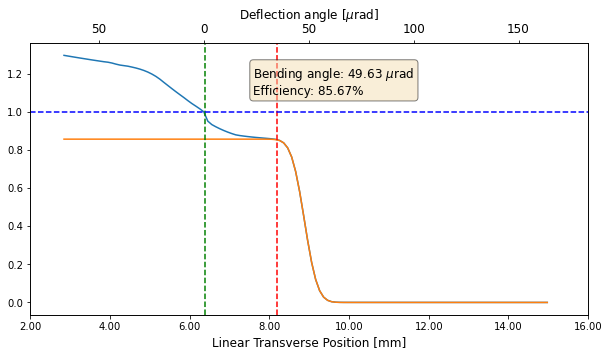

In [203]:
ax = linscan_sim(b, metadata_sim_450)
#ax.set_xlim(0.0, 0.01)
#ax.set_ylim(0,2.5)

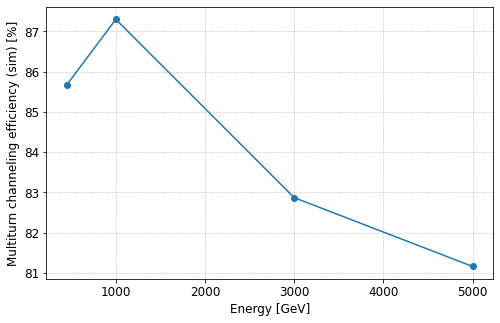

In [185]:
mt_dict = {450: 85.67, 1000: 87.30, 3000: 82.87, 5000: 81.16}
mt_df = pd.DataFrame.from_dict(mt_dict, orient='index', columns=['mt'])
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(mt_df.index, mt_df.mt, marker='o')
ax.set_xlabel('Energy [GeV]', fontsize=12)
ax.set_ylabel('Multiturn channeling efficiency (sim) [%]', fontsize=12)
ax.grid(linestyle=':')
ax.tick_params(axis='both', which='major', labelsize=12)

# ANG SCAN

In [3]:
def plot_angular_scan(data_dict, cry_name = 'CRY', normalize = False):
    fig, ax = plt.subplots(figsize=(11, 5))
    data_dict = data_dict.set_index('index').T.to_dict() if isinstance(data_dict, pd.DataFrame) else data_dict
    n_cry_abs = []
    angles = []
    norm_abs = []
    for key in data_dict.keys():
        n_cry_abs.append(data_dict[key][cry_name+'_abs'])
        angles.append(-1*data_dict[key]['angle'])
        norm_abs.append(data_dict[key][cry_name+'_abs'] / (data_dict[key]['npart'] ))

    if normalize:
        ax.plot(angles, norm_abs, marker='o')
    else:
        ax.plot(angles, n_cry_abs, marker='o')
    ax.set_xlabel(r'Angle [$\mu$rad]', fontsize=12)
    ax.set_ylabel('Absorbed particles [%]', fontsize=12)
    ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e6:.{0}f}" for x_tick in ax.get_xticks()])
    ax.set_yticks(ticks=ax.get_yticks(), labels=[f"{y_tick*1e3:.{2}f}" for y_tick in ax.get_yticks()])
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax2 = ax.twiny()
    reversed_angles = [-1*angle for angle in data_dict.keys()]
    ax2.plot(reversed_angles, norm_abs, alpha=0.0, color='k')
    ax2.set_xlabel('$\Delta$Angle [$\mu$rad]', fontsize=12)
    ax.grid(color='gray', linestyle='--', linewidth=0.5)
    #ax.set_yscale('log')
    return fig, ax, ax2

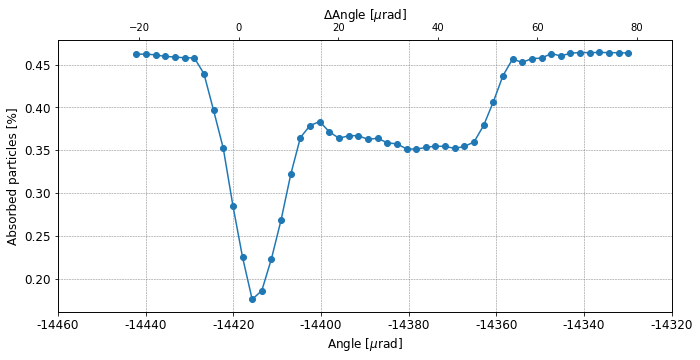

In [4]:
fig, ax, ax2 = plot_angular_scan(pd.read_hdf('./Plots/CRY_ang_scan_1TeV.h5'), normalize=True)

In [5]:
# DEF_PLOTS !!!!
fig.savefig('./DEF_PLOTS/MD_simulated_angscan.pdf', dpi=300)

In [6]:
df = pd.read_hdf('./Plots/CRY_ang_scan_1TeV.h5')

df["CRY_abs_tot"] = df["CRY_abs"]
df["CRY_abs"] = df["CRY_abs"]/df["npart"]
mean_amorph = np.mean(df[((df['index']>-81.5)& (df['index']<-59.0)) | ((df['index']>15.0)& (df['index']<31.0)) ]['CRY_abs'])
mean_std = np.std(df[((df['index']>-81.5)& (df['index']<-66.0)) | ((df['index']>4.4)& (df['index']<31.0)) ]['CRY_abs'])
df["CRY_abs"] = df["CRY_abs"]/mean_amorph

In [7]:
mean_amorph

0.0004600947368421052

In [8]:
def plot_angular_scan2(df):


    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(-df['angle'], df['CRY_abs'], marker='o')
    
    ax.set_xlim(-0.01449, -0.01429)
    ax.set_ylim(0.32, 1.1)
    xmin, xmax = ax.get_xlim()
    ticks  = np.arange(xmin, xmax+20e-6, 20e-6)
    ax.set_xticks(ticks)
    ax.set_xlabel(r'Angle [$\mu$rad]', fontsize=12)
    ax.set_ylabel('Absorbed particles', fontsize=12)
    ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e6:.{0}f}" for x_tick in ax.get_xticks()])
    #ax.set_yticks(ticks=ax.get_yticks(), labels=[f"{y_tick*1e3:.{2}f}" for y_tick in ax.get_yticks()])
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax2 = ax.twiny()
    idx  = df[df.CRY_abs == min(df.CRY_abs)].index[0]
    
    ang = -df.iloc[idx].angle
    ax2.set_xlim((xmin - ang)*1e6, (xmax - ang)*1e6)
    ax2.set_xlabel('$\Delta$Angle [$\mu$rad]', fontsize=12)
    #ax2.axvline(0, color='grey', linestyle='--')


    ax.grid(color='gray', linestyle='--', linewidth=0.5)
    
    return fig, ax, ax2

In [34]:
dp = 1.92e-10 
pot_crit = 21.34
eta = 0.9

def calculate_Rc(pc, bending_radius = 80 ):
    return  pc/(2*np.sqrt(eta)*pot_crit) * (dp/2)

def calculate_xpcrit(pc, bending_radius = 80.00):   
    Rcrit = calculate_Rc(pc, bending_radius)
    xp_crit = np.sqrt(2*eta*pot_crit/pc)*(1 - Rcrit/bending_radius)
    return xp_crit

In [35]:
xpcrit = calculate_xpcrit(1e12)
xpcrit

6.0140584916592415e-06

mean:  -14414.396286129291
sigma:  6.7133827506796815e-06
xp_crit:  6.0140584916592415e-06
xrange:  1.8000000000000654e-05


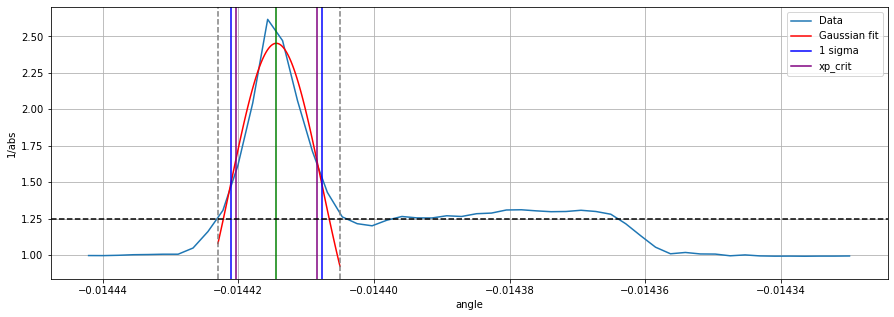

In [33]:
fig, ax = plt.subplots(figsize=(15, 5))

# Define Gaussian function
def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))
x = -df['angle'].values
y = 1/df['CRY_abs'].values

# Set fitting limits
x_min, x_max = -14423e-6, -14405e-6 #-14422e-6, -14407e-6#-14425e-6, -14405e-6
mask = (x >= x_min) & (x <= x_max)
x_fit = x[mask]
y_fit = y[mask]
popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=[max(y_fit), x_fit[np.argmax(y_fit)], 0.00001])
ax.plot(x, y, label="Data")
x_lin_fit = np.linspace(x_min, x_max, 100)
ax.plot(x_lin_fit, gaussian(x_lin_fit, *popt), color='red', label="Gaussian fit")
ax.axvline(x_min, color='gray', linestyle='--')
ax.axvline(x_max, color='gray', linestyle='--')

ax.set_ylabel("1/abs")
ax.set_xlabel("angle")
ax.grid(True)
ax.axvline(popt[1], color='green', linestyle='-')
ax.axvline(popt[1] + 1*popt[2], color='blue', linestyle='-', label='1 sigma')
ax.axvline(popt[1] - 1*popt[2], color='blue', linestyle='-')
ax.axvline(popt[1] + xpcrit, color='purple', linestyle='-', label='xp_crit')
ax.axvline(popt[1] - xpcrit, color='purple', linestyle='-')
ax.axhline(1.25, color='black', linestyle='--')

print('mean: ', popt[1]*1e6)
print('sigma: ', popt[2])
print('xp_crit: ', xpcrit)
print("xrange: ", np.abs(x_max-x_min))

ax.legend() 


In [25]:
x_fit[np.argmax(y_fit)]

-0.0144156698

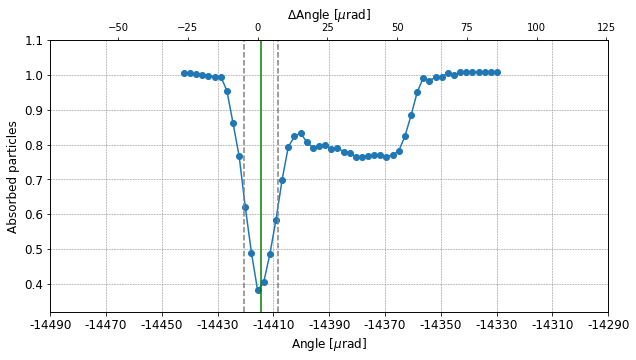

In [29]:
fig, ax, ax2  = plot_angular_scan2(df)
#ax2.axvline(0, color='green', linestyle='-')
xpcrit = calculate_xpcrit(1000e9)
ax.axvline(popt[1], color='green', linestyle='-')
ax.axvline((popt[1]+xpcrit), color='grey', linestyle='--')
ax.axvline((popt[1]-xpcrit), color='grey', linestyle='--')

#ax.axvline(-14425e-6, color='red', linestyle='--')
#ax.axvline(-14405e-6, color='red', linestyle='--')
ax.plot(x_fit, gaussian(x_fit, *popt), color='red', label="Gaussian fit")

In [12]:
#fig.savefig('./DEF_PLOTS/MD_simulated_angscan.pdf', dpi=300)

In [22]:
df

,index,CRY_abs,angle,align_angle,npart,CRY_abs_tot
0,-81.4,1.007184,-0.014330,0.000006,5000000.0,2317.0
1,-79.2,1.008053,-0.014332,0.000008,5000000.0,2319.0
2,-77.0,1.008053,-0.014334,0.000010,5000000.0,2319.0
3,-74.8,1.008923,-0.014336,0.000012,5000000.0,2321.0
4,-72.6,1.008053,-0.014339,0.000015,5000000.0,2319.0
5,-70.4,1.008488,-0.014341,0.000017,5000000.0,2320.0
6,-68.2,1.006749,-0.014343,0.000019,5000000.0,2316.0
7,-66.0,0.999794,-0.014345,0.000021,5000000.0,2300.0
8,-63.8,1.005880,-0.014347,0.000023,5000000.0,2314.0
9,-61.6,0.994143,-0.014350,0.000026,5000000.0,2287.0


In [23]:
df.to_hdf('./Data/Ang_scan_1TeV.h5', key='CRY_ang_scan', format='table', mode='a', complevel=9, complib='blosc')